# Chapter 1 - Introduction

In [4]:
cmd_folder = '../../gssr' # Insert here the string pointing to the gssr root folder

# Make sure the gssr folder is in the python path
import os, sys
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# Import the needed gssr modules
import utils
import plotting
    
import graphs_signals as gs
import sampling as smp
import recovery as rec

In [23]:
import helper

import pygsp
pygsp.plotting.BACKEND = 'matplotlib'

import pyunlocbox

import numpy as np
np.random.seed(42) # For reproducibility

import matplotlib.pyplot as plt
plt.style.use('thesis.mplstyle')

helper.set_pgf_preamble()

%matplotlib inline

In [13]:
data_path = os.path.join(cmd_folder, 'data/swiss-national-council')
save_path = '../latex/images/'
helper.set_cmap('quantized')

# Load the data

In [18]:
nn_params = {'NNtype': 'knn',
             'use_flann': True,
             'center': False,
             'rescale': True,
             'k': 25,
             'dist_type': 'euclidean'}
graph, indicator_vectors = gs.swiss_national_council(path=data_path, **nn_params)
signal = graph.info['node_com']
party_colors = graph.info['councillors']['PartyColor']

# The council and parties

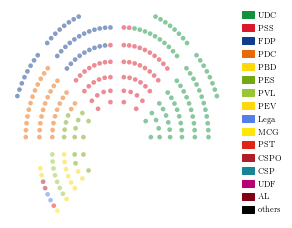

In [46]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, party_colors, ax=ax, edges=False, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_parties_no_edges.pdf'))
plt.show()

# Network of voting similarity

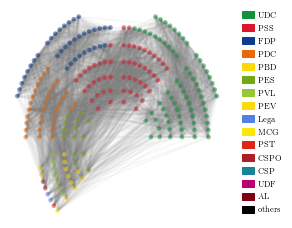

In [47]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, party_colors, ax=ax, edges=True, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_parties_with_edges.pdf'))
plt.show()

# Subsampled party colors

In [24]:
smp_design = lambda g, m: smp.uniform_vertex(g, m, replace=True)

m = int(0.5 * graph.n_vertices)

sampled_vertices = smp_design(graph, m)

sampled_party_colors = np.asarray(['#FFFFFF'] * len(party_colors))
sampled_party_colors[sampled_vertices] = party_colors[sampled_vertices]

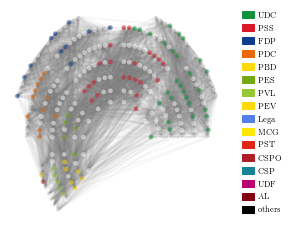

In [45]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, sampled_party_colors, ax=ax, edges=True, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_subsampled_parties_with_edges.pdf'))
plt.show()

# A numerical example 

In [32]:
parties = graph.info['parties']
parties_in_gt = ['UDC']
cls_mask = [False] * len(parties)
for p in parties_in_gt:
    cls_mask += (parties == p)

signal = np.sum(indicator_vectors[cls_mask,:], axis=0)

In [33]:
rtol = 1e-6 * (graph.n_vertices ** (-1/2))
maxit = 5000
verbosity = 'LOW'
rec_fun = lambda g, s_ver, s_val: rec.tv_interpolation(g, s_ver, s_val, rtol=rtol, maxit=maxit, verbosity=verbosity)

In [34]:
# Subsample
sampled_vertices = smp_design(graph, m)
sampled_values = signal[sampled_vertices]
y = utils.nan_off_sample(graph.n_vertices, sampled_vertices, sampled_values)

# Recover
recovered_signal = rec_fun(graph, sampled_vertices, sampled_values)

Solution found after 726 iterations:
    objective function f(sol) = 1.468557e+02
    stopping criterion: RTOL


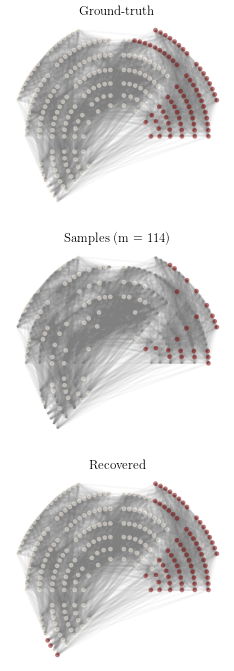

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(3.94, 11.82))
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3.94, 1.31))

limits = [min(signal), max(signal)]

plotting.plot_graph(graph, 
                    signal, 
                    ax=ax[0], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

plotting.plot_graph(graph, 
                    y, 
                    ax=ax[1], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

plotting.plot_graph(graph, 
                    recovered_signal, 
                    ax=ax[2], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

ax[0].set(title=r'Ground-truth')
ax[1].set(title='Samples (m = {0})'.format(m))
ax[2].set(title='Recovered')

plt.savefig(os.path.join(save_path, 'snc_sample_rec_example.pdf'))
plt.show()